<a href="https://www.kaggle.com/code/sedadlger/anova-wa-marketing-campaign?scriptVersionId=149590445" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Bir fast food zinciri menüsüne üç farklı promosyon eklemek istiyor. 
Ancak hangi kampanyayı promosyon olarak eklemek istedikleri konusunda kararsız kalmaktadırlar.
Hangi promosyonun satışlarda daha etkili olduğunu görmek adına çeşitli
lokasyonlarda seçilmiş marketlerde bu promosyonlar uygulanmıştır.

* MarketID: unique identifier for market
* MarketSize: size of market area by sales
* LocationID: unique identifier for store location
* AgeOfStore: age of store in years
* Promotion: one of three promotions that were tested
* week: one of four weeks when the promotions were run
* SalesInThousands: sales amount for a specific LocationID, Promotion, and week

In [1]:
# Kuullanacağımız kütüphaneleri yükleyelim;
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install statsmodels
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest


# Satır-Sutun Görüntüleme ayarlarını yapalım ve dataframe'i yükleyelim;
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df = pd.read_csv("/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv")

Görev 1: Verileri analiz ediniz.

In [2]:
df.head() #ilk 5 gözlem birimini inceleyelim:

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73000
1,1,Medium,1,4,3,2,35.67000
2,1,Medium,1,4,3,3,29.03000
3,1,Medium,1,4,3,4,39.25000
4,1,Medium,2,5,2,1,27.81000


In [3]:
df.info() #değişken tiplerimize bakalım

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [4]:
df.describe().T # Sayısal değişkenlerin betimsel istatistiklerini inceleyelim:

,count,mean,std,min,25%,50%,75%,max
MarketID,548.00000,5.71533,2.87700,1.00000,3.00000,6.00000,8.00000,10.00000
LocationID,548.00000,479.65693,287.97368,1.00000,216.00000,504.00000,708.00000,920.00000
AgeOfStore,548.00000,8.50365,6.63835,1.00000,4.00000,7.00000,12.00000,28.00000
Promotion,548.00000,2.02920,0.81073,1.00000,1.00000,2.00000,3.00000,3.00000
week,548.00000,2.50000,1.11906,1.00000,1.75000,2.50000,3.25000,4.00000
SalesInThousands,548.00000,53.46620,16.75522,17.34000,42.54500,50.20000,60.47750,99.65000


In [5]:
df.isnull() #dataframe içerisinde eksik değer var mı bakalım:

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
543,False,False,False,False,False,False,False
544,False,False,False,False,False,False,False
545,False,False,False,False,False,False,False
546,False,False,False,False,False,False,False


In [6]:
df.nunique() #dataframe içerisindeki her bir değişken için eşsiz değer sayısına bakalım:

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

In [7]:
df["Promotion"].nunique() #uygulanan farklı promosyon sayısını görelim:

3

In [8]:
df["LocationID"].nunique() #kaç farklı lokasyonda uygulanmış görelim:

137

In [9]:
df.groupby(['Promotion', 'MarketSize'])['LocationID'].agg(['count']) 
# Bu üç promosyon market büyüklüğüne göre nasıl dağıtılmış görelim:

count
Promotion MarketSize       
1         Large          56
          Medium         96
          Small          20
2         Large          64
          Medium        108
          Small          16
3         Large          48
          Medium        116
          Small          24

In [10]:
df.groupby('Promotion').agg({"SalesInThousands": "mean"})
# Bu üç promosyonun ortalama satışları ne olmuş görelim:


,SalesInThousands
Promotion,
1,58.09901
2,47.32941
3,55.36447


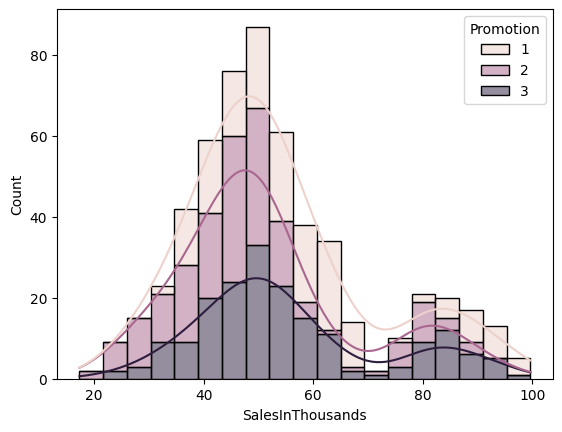

In [11]:
sns.histplot(data=df, x='SalesInThousands', hue='Promotion', multiple='stack', kde=True)
plt.show(block=True)
# bu promosyonların dağılımlarını görelim:

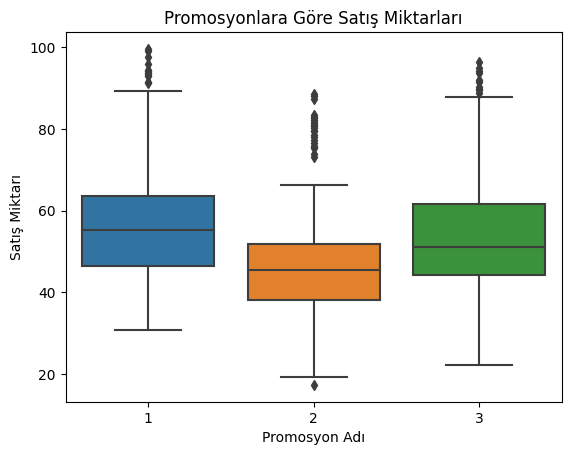

In [12]:
sns.boxplot(x='Promotion', y='SalesInThousands', data=df)
plt.title('Promosyonlara Göre Satış Miktarları')
plt.xlabel('Promosyon Adı')
plt.ylabel('Satış Miktarı')
plt.show(block=True)

Boxplot grafiğine baktığımızda outliers'lar görüyoruz bunları uzaklaştırmamız halinde daha temiz bir veri seti ile çalışabiliriz:

In [13]:
def remove_outliers(dataframe, col_name, promo_type):
    df_p = dataframe[dataframe['Promotion'] == promo_type]
    quartile1 = np.percentile(df_p[col_name], 25)
    quartile3 = np.percentile(df_p[col_name], 75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return df_p[(df_p[col_name] >= low_limit) & (df_p[col_name] <= up_limit)]

In [14]:
df_no1 = remove_outliers(df, "SalesInThousands", 1)
df_no1.shape

(160, 7)

In [15]:
df_no2 = remove_outliers(df, "SalesInThousands", 2)
df_no2.shape

(164, 7)

In [16]:
df_no3 = remove_outliers(df, "SalesInThousands", 3)
df_no3.shape

(178, 7)

In [17]:
df_clean = pd.concat([df_no1, df_no2, df_no3], axis=0) #Her bir promosyon için outliersları uzaklaşatırdık ve yeni bir df oluşturduk.
df_clean.reset_index(drop=True, inplace=True) # İndeksleri resetledik
df_clean.head() #ilk beş gözlem

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,3,12,1,1,44.54000
1,1,Medium,3,12,1,2,37.94000
2,1,Medium,3,12,1,3,45.49000
3,1,Medium,3,12,1,4,34.75000
4,1,Medium,7,15,1,1,42.92000


In [18]:
df_clean.shape

(502, 7)

In [19]:
df.shape 

(548, 7)

46 gözlem biriminin uzaklaşmış olduğu görünüyor

Görev 2:  A/B Testinin Hipotezinin Tanımlanması

Hipotezleri kuralım:


* H0: M1 = M2 = M3 Promosyon ortalamaları arasında fark yok
* H1: M1 != M2 = M3 Promosyon ortalamaları arasından en az biri farklı

Promosyonlara göre satış ortalamalarını analiz ediniz:

In [20]:
df_clean.groupby('Promotion').agg({"SalesInThousands": "mean"})

,SalesInThousands
Promotion,
1,55.34519
2,42.90610
3,53.29798


Görev 3: Hipotez Testinin Gerçekleştirilmesi

In [21]:
# Dağılım normal mi ona bakalım:

for group in list(df_clean["Promotion"].unique()):
    pvalue = shapiro(df_clean.loc[df_clean["Promotion"] == group, "SalesInThousands"])[1]
    print(group, 'p-value: %.4f' % pvalue)

1 p-value: 0.0000
2 p-value: 0.0130
3 p-value: 0.0000


In [22]:
# p_value<0,05 ho red edilir, dağılım normal değildir

# Non-parametrik anova testi:

print(kruskal(df_clean.loc[df_clean["Promotion"] == 1, "SalesInThousands"],
              df_clean.loc[df_clean["Promotion"] == 2, "SalesInThousands"],
              df_clean.loc[df_clean["Promotion"] == 3, "SalesInThousands"])[1])

4.111732025490055e-18


p value değeri < 0.05'den H0 red edilir, eldeki verilere göre bu üç promosyonun ortalama etkisi arasında anlamlı bir fark vardır.

In [23]:
# Eğer outliers'ları temizlemeseydik:

df = pd.read_csv("/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv")

In [24]:
df.groupby('Promotion').agg({"SalesInThousands": "mean"})

,SalesInThousands
Promotion,
1,58.09901
2,47.32941
3,55.36447


In [25]:
for group in list(df["Promotion"].unique()):
    pvalue = shapiro(df.loc[df["Promotion"] == group, "SalesInThousands"])[1]
    print(group, 'p-value: %.9f' % pvalue)

3 p-value: 0.000000015
2 p-value: 0.000000005
1 p-value: 0.000000020


Dağılım yine normal bir dağılım olmayacaktı;

In [26]:
print(kruskal(df.loc[df["Promotion"] == 1, "SalesInThousands"],
              df.loc[df["Promotion"] == 2, "SalesInThousands"],
              df.loc[df["Promotion"] == 3, "SalesInThousands"])[1])

2.6741866266697816e-12


Kruskal testinde aldığımz p value değerine göre de;
HO hipotezi red edilecek ve ortalama etkilerden yine en az biri farklı olacaktı.            
Burada önemli olan nokta veriyi ele alış şeklimizdir, buna göre değerlerde farklılıklar gözlemlenebilir.
Buradan sonra Tukey testleri ile ikili ortalamalar karşılaştırılabilir.

Teşekkürler:)